In [1]:
import xarray as xr
import numpy as np
import datetime as dt
import glob
import matplotlib.pyplot as plt
import netCDF4 as nc
import cartopy.crs as ccrs
import pandas as pd
import tqdm
import metpy.calc as mpcalc
import metpy.units as units
from sklearn.cluster import KMeans as kmeans
import seaborn as sns

def get_lat_lon_barra():
        ta_file = nc.Dataset(glob.glob("/g/data/cj37/BARRA/BARRA_R/v1/analysis/prs/air_temp/"\
        +"2012"+"/"+"12"+"/air_temp-an-prs-PT0H-BARRA_R-v1-"+"2012"+"12"+"01"+"T"+"00"+"*.nc")[0])
        lon = ta_file["longitude"][:]
        lat = ta_file["latitude"][:]
        return [lon,lat]

def get_mask_barra(lon,lat):

        #Take 1d lat lon data from an already-loaded BARRA-R domain (e.g. sa_small or aus) and return a land-sea mask
        nat_lon,nat_lat = get_lat_lon_barra()
        lon_ind = np.where((nat_lon >= lon[0]) & (nat_lon <= lon[-1]))[0]
        lat_ind = np.where((nat_lat >= lat[0]) & (nat_lat <= lat[-1]))[0]
        lsm = nc.Dataset("/g/data/cj37/BARRA/BARRA_R/v1/static/lnd_mask-an-slv-PT0H-BARRA_R-v1.nc").variables["lnd_mask"][:]
        lsm_domain = lsm[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]

        return lsm_domain

def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)
                        
        R = 6373.0
                        
        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)
                
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)

def get_mask(lon,lat,thresh=0.5):
    #Return lsm for a given domain (with lats=lat and lons=lon)
    lsm,nat_lon,nat_lat = get_lsm()
    lon_ind = np.where((nat_lon >= lon[0]) & (nat_lon <= lon[-1]))[0]
    lat_ind = np.where((nat_lat >= lat[-1]) & (nat_lat <= lat[0]))[0]
    lsm_domain = lsm[(lat_ind[0]):(lat_ind[-1]+1),(lon_ind[0]):(lon_ind[-1]+1)]
    lsm_domain = np.where(lsm_domain > thresh, 1, 0)

    return lsm_domain

def get_lsm():
    #Load the ERA5 land-sea fraction
    lsm_file = nc.Dataset("/g/data/rt52/era5/single-levels/reanalysis/lsm/1979/lsm_era5_oper_sfc_19790101-19790131.nc")
    lsm = np.squeeze(lsm_file.variables["lsm"][0])
    lsm_lon = np.squeeze(lsm_file.variables["longitude"][:])
    lsm_lat = np.squeeze(lsm_file.variables["latitude"][:])
    lsm_file.close()
    return [lsm,lsm_lon,lsm_lat]

def get_point_data(time,lat,lon,r,var,plot=False,vmin=None,vmax=None):
    
    f = xr.open_dataset(glob.glob("/g/data/eg3/ab4502/ExtremeWind/aus/era5/era5_"\
                            +time.strftime("%Y%m")+"*.nc")[0])[var].sel({"time":time.replace(minute=0)})
    
    lats = f.coords.get("lat").values
    lons = f.coords.get("lon").values
    x,y = np.meshgrid(lons,lats)
    dist_km = (latlon_dist(lat, lon, y, x) )
    mask = get_mask(lons,lats)
    a,b = np.where( (dist_km <= r) & (mask == 1) )
    target_lons = xr.DataArray(lons[b],dims="points")
    target_lats = xr.DataArray(lats[a],dims="points")    
    f_slice = (f.sel(lon=target_lons, lat=target_lats))
    
    if plot:
        plt.figure()
        ax=plt.axes(projection=ccrs.PlateCarree())
        temp = np.where((dist_km <= r) & (mask == 1), f.values, np.nan)
        c=ax.pcolormesh(x,y,temp,vmin=vmin,vmax=vmax)
        plt.colorbar(c)
        ax.coastlines()
    
    #Return the value of the point with the highest absolute value
    return pd.DataFrame([f_slice[v].values[np.abs(f_slice[v]).argmax()] for v in var], index=var)

def synoptic_diagnostics(domain, time):

    lon1, lat1, lon2, lat2 = domain

    #Calculate the 850 hPa wet bulb potential temperature gradient
    fq=xr.open_dataset(glob.glob("/g/data/rt52/era5/pressure-levels/reanalysis/q/"+time.strftime("%Y")+"/q_era5_oper_pl_"+time.strftime("%Y%m")+"*.nc")[0])\
                   .sel({"time":time.replace(minute=0), "level":slice(850,850)}).sel({"longitude":slice(lon1,lon2), "latitude":slice(lat2,lat1)}).metpy.assign_crs(grid_mapping_name='latitude_longitude').q#.metpy.parse_cf("q")
    ft=xr.open_dataset(glob.glob("/g/data/rt52/era5/pressure-levels/reanalysis/t/"+time.strftime("%Y")+"/t_era5_oper_pl_"+time.strftime("%Y%m")+"*.nc")[0])\
                   .sel({"time":time.replace(minute=0), "level":slice(850,850)}).sel({"longitude":slice(lon1,lon2), "latitude":slice(lat2,lat1)}).metpy.assign_crs(grid_mapping_name='latitude_longitude').t#.metpy.parse_cf("t")
    fdp = mpcalc.dewpoint_from_specific_humidity(850*units.units.hectopascal, ft, fq)

    p3d = xr.DataArray(data = np.ones(ft.shape) * 85000, coords=ft.coords, dims=ft.dims, attrs={"units":"Pa"})
    wb = wrf.wetbulb(p3d, ft, fq, meta=True)
    wb_pot = mpcalc.potential_temperature(p3d, wb).isel({"level":0})
    dlat, dlon = mpcalc.gradient(wb_pot.coarsen({"latitude":4, "longitude":4},boundary="pad").mean())
    wb_pot_grad = np.sqrt(np.square(dlat) + np.square(dlon)).metpy.convert_units("K/km")

    #Calculate the 500 hPa geostrophic vorticity
    fz=xr.open_dataset(glob.glob("/g/data/rt52/era5/pressure-levels/reanalysis/z/"+time.strftime("%Y")+"/z_era5_oper_pl_"+time.strftime("%Y%m")+"*.nc")[0])\
                .sel({"time":time.replace(minute=0), "level":slice(500,500)})\
                .sel({"longitude":slice(lon1,lon2), "latitude":slice(lat2,lat1)})\
                .metpy.assign_crs(grid_mapping_name='latitude_longitude').z\
                .coarsen({"latitude":4, "longitude":4}, boundary="pad").mean().isel({"level":0})
    lons, lats = np.meshgrid(fz.longitude, fz.latitude)
    f=mpcalc.coriolis_parameter(lats * units.units.degree)
    laplacian = (mpcalc.laplacian(fz) / f)
    
    return wb_pot_grad, laplacian

def get_point_data_barra(time,lat,lon,r,var,plot=False,vmin=None,vmax=None):
    
    f = xr.open_dataset(glob.glob("/g/data/eg3/ab4502/ExtremeWind/aus/barra_fc/barra_fc_"\
                            +time.strftime("%Y%m%d")+"*.nc")[0])[var].sel({"time":time.replace(minute=0)})
    
    lats = f.coords.get("lat").values
    lons = f.coords.get("lon").values
    x,y = np.meshgrid(lons,lats)
    dist_km = (latlon_dist(lat, lon, y, x) )
    mask = get_mask_barra(lons,lats)
    a,b = np.where( (dist_km <= r) & (mask == 1) )
    target_lons = xr.DataArray(lons[b],dims="points")
    target_lats = xr.DataArray(lats[a],dims="points")    
    f_slice = (f.sel(lon=target_lons, lat=target_lats))
    
    if plot:
        plt.figure()
        ax=plt.axes(projection=ccrs.PlateCarree())
        temp = np.where((dist_km <= r) & (mask == 1), f.values, np.nan)
        c=ax.pcolormesh(x,y,temp,vmin=vmin,vmax=vmax)
        plt.colorbar(c)
        ax.coastlines()
    
    #Return the value of the point with the highest absolute value
    return pd.DataFrame([f_slice[v].values[np.abs(f_slice[v]).argmax()] for v in var], index=var)

def get_point_data_from_da(f,lat,lon,r,plot=False,vmin=None,vmax=None):
    lats = f.coords.get("latitude").values
    lons = f.coords.get("longitude").values
    x,y = np.meshgrid(lons,lats)
    dist_km = (latlon_dist(lat, lon, y, x) )
    a,b = np.where( (dist_km <= r) )
    target_lons = xr.DataArray(lons[b],dims="points")
    target_lats = xr.DataArray(lats[a],dims="points")    
    f_slice = (f.sel(longitude=target_lons, latitude=target_lats))
    
    if plot:
        plt.figure()
        ax=plt.axes(projection=ccrs.PlateCarree())
        temp = np.where((dist_km <= r), f.values, np.nan)
        c=ax.pcolormesh(x,y,temp,vmin=vmin,vmax=vmax)
        plt.colorbar(c)
        ax.coastlines()
    
    #Return the value of the point with the highest absolute value
    return f_slice.values[np.abs(f_slice).argmax()]

In [2]:
details_list = [\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2006,9,24,1,41)], "rid":"2", "title":"a) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2009,11,20,3,6)], "rid":"2", "title":"b) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2010,3,6,3,30)], "rid":"2", "title":"c) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2010,6,17,0,25)], "rid":"2", "title":"d) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2011,11,18,7,4)], "rid":"2", "title":"e) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2011,12,25,6,45)], "rid":"2", "title":"f) Melbourne:  UTC" },\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2012,2,26,9,11)], "rid":"2", "title":"g) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2013,3,21,3,45)], "rid":"2", "title":"h) Melbourne: UTC" },\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2015,2,28,9,25)], "rid":"2", "title":"i) Melbourne:  UTC"},\
       \
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2010,8,2,15,43)], "rid":"71", "title":"a) Sydney:  UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2012,8,10,4,21)], "rid":"71", "title":"b) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2013,2,23,13,43)], "rid":"71", "title":"c) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2014,10,14,11,39)], "rid":"71", "title":"d) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2015,3,1,4,34)], "rid":"71", "title":"e) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2015,12,16,2,3)], "rid":"71", "title":"f) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2016,1,14,4,20)], "rid":"71", "title":"g) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2016,6,4,3,42)], "rid":"71", "title":"h) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2017,4,9,8,3)], "rid":"71", "title":"i) Sydney: UTC"},\
       \
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2010,12,16,3,25)], "rid":"66", "title":"a) Amberley: UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2011,1,18,5,5)], "rid":"66", "title":"b) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2011,10,7,19,22)], "rid":"50", "title":"c) Oakey: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2013,10,18,4,4)], "rid":"50", "title":"d) Oakey: UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2013,11,23,9,45)], "rid":"66", "title":"e) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2014,1,23,4,52)], "rid":"50", "title":"f) Oakey UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2016,1,29,4,22)], "rid":"50", "title":"g) Oakey UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2016,12,18,4,14)], "rid":"66", "title":"h) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2018,2,13,7,5)], "rid":"50", "title":"i) Oakey: UTC"},\
       \
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2007,10,27,9,3)], "rid":"27", "title":"a) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2008,12,9,6,18)], "rid":"27", "title":"b) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2010,12,7,9,27)], "rid":"27", "title":"c) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2011,11,8,9,47)], "rid":"27", "title":"d) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2012,1,29,4,42)], "rid":"27", "title":"e) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2012,11,30,8,33)], "rid":"27", "title":"f) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2014,10,31,7,52)], "rid":"27", "title":"g) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2015,12,7,11,20)], "rid":"27", "title":"h) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2017,12,18,11,30)], "rid":"27", "title":"i) "},\
         ]

In [3]:
var=["s06","qmean01","lr13","Umean06"]

df = pd.DataFrame()
df_barra = pd.DataFrame()
for details in tqdm.tqdm(details_list):
    df = pd.concat([df, 
       get_point_data(details["time"][0], details["lat"], details["lon"], 50, var, plot=False).T],
                  axis=0)
    df_barra = pd.concat([df_barra, 
        get_point_data_barra(details["time"][0], details["lat"], details["lon"], 50, var, plot=False).T],
                   axis=0)

100%|██████████| 36/36 [00:58<00:00,  1.64s/it]


                  time rid  cluster
0  2006-09-24 01:41:00   2        0
1  2009-11-20 03:06:00   2        2
2  2010-03-06 03:30:00   2        1
3  2010-06-17 00:25:00   2        0
4  2011-11-18 07:04:00   2        2
5  2011-12-25 06:45:00   2        1
6  2012-02-26 09:11:00   2        1
7  2013-03-21 03:45:00   2        0
8  2015-02-28 09:25:00   2        2
9  2010-08-02 15:43:00  71        0
10 2012-08-10 04:21:00  71        0
11 2013-02-23 13:43:00  71        1
12 2014-10-14 11:39:00  71        0
13 2015-03-01 04:34:00  71        1
14 2015-12-16 02:03:00  71        1
15 2016-01-14 04:20:00  71        1
16 2016-06-04 03:42:00  71        0
17 2017-04-09 08:03:00  71        0
18 2010-12-16 03:25:00  66        1
19 2011-01-18 05:05:00  66        1
20 2011-10-07 19:22:00  50        1
21 2013-10-18 04:04:00  50        1
22 2013-11-23 09:45:00  66        1
23 2014-01-23 04:52:00  50        1
24 2016-01-29 04:22:00  50        1
25 2016-12-18 04:14:00  66        1
26 2018-02-13 07:05:00  50  

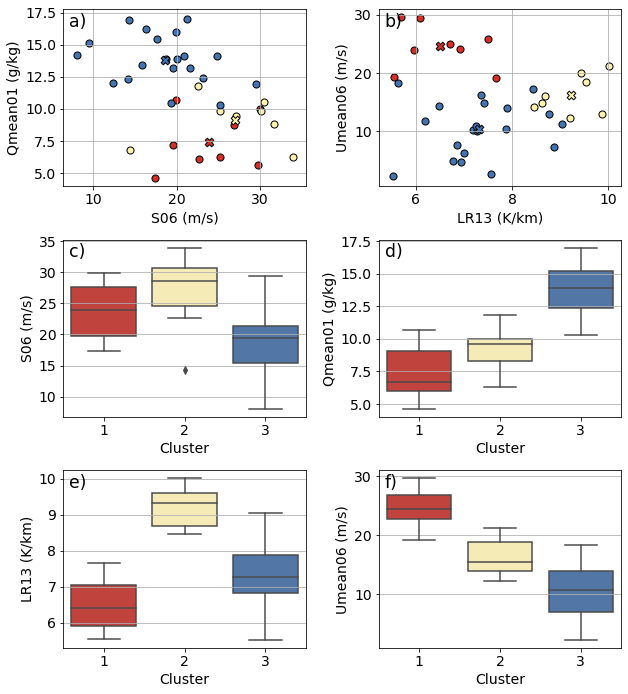

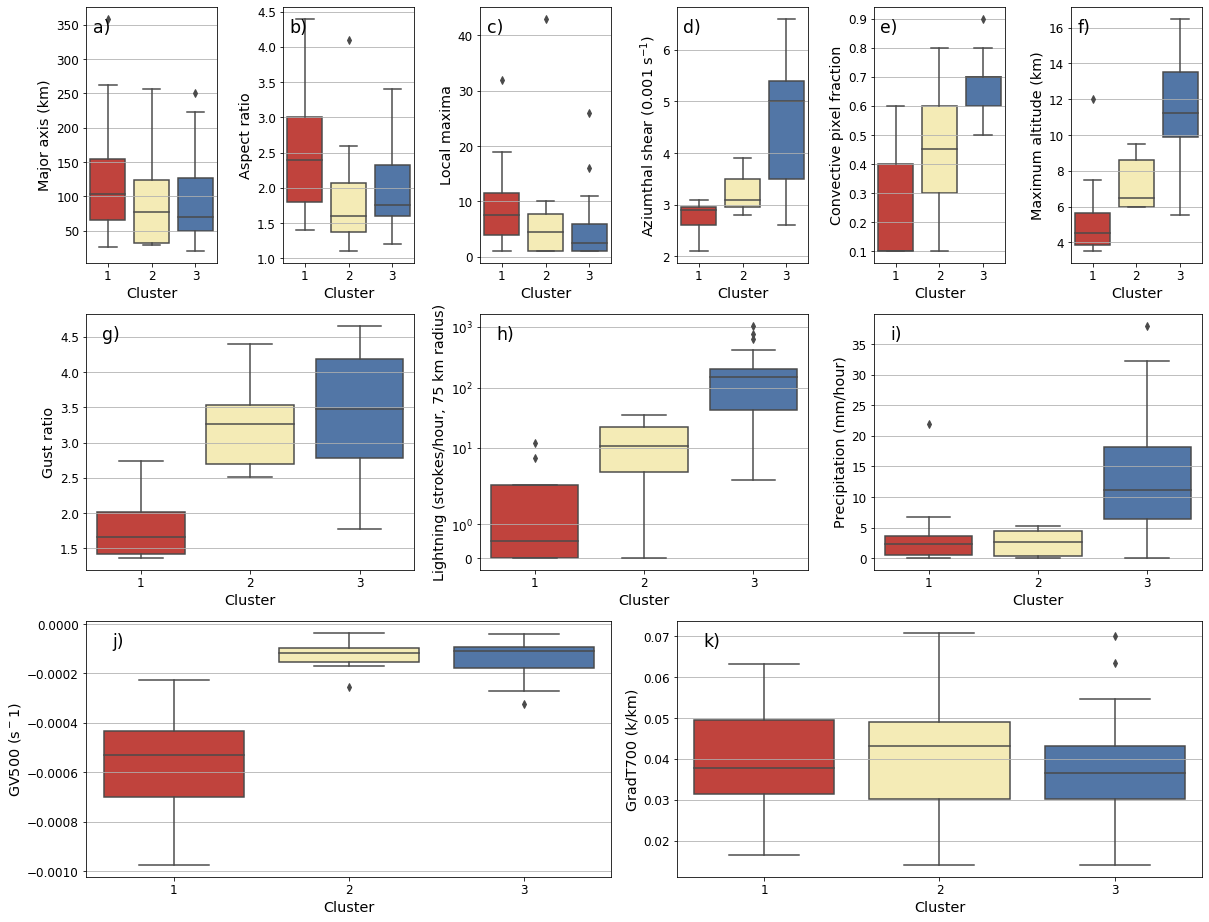

In [4]:
df_norm = (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))

mod=kmeans(n_clusters=3, verbose=0, random_state=0)
mod_fit=mod.fit(df_norm[var])
cluster_index = mod_fit.predict(df_norm[var])

#p = [plt.get_cmap("RdYlBu")(i) for i in np.linspace(0,1,len(np.unique(cluster_index)))]
p = [plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]

plt.figure(figsize=[10,16])
plt.rcParams.update({'axes.labelsize': 'medium', 'xtick.labelsize': 'medium', 'ytick.labelsize': 'medium'})

specify_order=True
order=[0,2,1]

ylabs = ["S06 (m/s)","Qmean01 (g/kg)","LR13 (K/km)","Umean06 (m/s)"]
letters = ["a","b","c","d","e","f","g","h","i","j","k"]

cnt=3
for v in df.columns:
    plt.subplot(np.ceil((df.shape[1]) / 2)+2,2,cnt)
    plt.text(0.025,0.9,letters[cnt-1]+")",transform=plt.gca().transAxes,size="xx-large")
    if specify_order:
        sns.boxplot(data=[df.loc[cluster_index==c][v] for c in order], palette=p)
        plt.xticks(np.arange(len(np.unique(cluster_index))), order)
    else:
        sns.boxplot(data=[df.loc[cluster_index==c][v] for c in np.unique(cluster_index)], palette=p)
    if v in ["mu_cape"]:
        plt.yscale("symlog")
        plt.ylim([0,10000])
    plt.gca().grid(axis="y")
    plt.ylabel(ylabs[cnt-3],size=14)
    plt.xticks(ticks=[0,1,2],labels=[1,2,3])
    plt.xlabel("Cluster",size=14)
    plt.gca().tick_params(labelsize=14)
    cnt=cnt+1

#SCATTERPLOTS
if specify_order:
    cnt=0
    plt.subplot(np.ceil((df.shape[1]) / 2)+2,2,1)
    plt.text(0.025,0.9,letters[0]+")",transform=plt.gca().transAxes,size="xx-large")
    for c in order:
        plt.scatter(df.loc[cluster_index==c][var[0]], df.loc[cluster_index==c][var[1]], c=[p[cnt]], edgecolors="k", s=50)
        plt.scatter(np.interp(mod_fit.cluster_centers_[c,np.where(np.array(var)==var[0])[0][0]], np.sort(df_norm[var[0]].values), np.sort(df[var[0]].values)),
                    np.interp(mod_fit.cluster_centers_[c,np.where(np.array(var)==var[1])[0][0]], np.sort(df_norm[var[1]].values), np.sort(df[var[1]].values)), c=[p[cnt]], marker="X", edgecolors="k",s=75)
        cnt=cnt+1
    if var[1] == "mu_cape":
        plt.yscale("symlog"); plt.ylim([0,10000]); 
    plt.gca().grid(); plt.xlabel("S06 (m/s)",size=14); plt.ylabel("Qmean01 (g/kg)",size=14)
    plt.gca().tick_params(labelsize=14)
        
    cnt=0
    plt.subplot(np.ceil((df.shape[1]) / 2)+2,2,2)
    plt.text(0.025,0.9,letters[1]+")",transform=plt.gca().transAxes,size="xx-large")
    for c in order:
        plt.scatter(df.loc[cluster_index==c][var[2]], df.loc[cluster_index==c][var[3]], c=[p[cnt]], edgecolors="k", s=50)
        plt.scatter(np.interp(mod_fit.cluster_centers_[c,np.where(np.array(var)==var[2])[0][0]], np.sort(df_norm[var[2]].values), np.sort(df[var[2]].values)),
                    np.interp(mod_fit.cluster_centers_[c,np.where(np.array(var)==var[3])[0][0]], np.sort(df_norm[var[3]].values), np.sort(df[var[3]].values)), c=[p[cnt]], marker="X", edgecolors="k",s=75)        
        cnt=cnt+1
    plt.gca().grid(); plt.ylabel("Umean06 (m/s)",size=14); plt.xlabel("LR13 (K/km)",size=14); plt.gca().tick_params(labelsize=14)

else:
    for c in np.arange(len(np.unique(cluster_index))):
        plt.scatter(df.loc[cluster_index==c][var[1]], df.loc[cluster_index==c][var[0]], c=[p[c]], edgecolors="k")
    if var[1] == "mu_cape":
        plt.yscale("symlog"); plt.ylim([0,10000])
    plt.gca().grid(axis="y")

    plt.figure()
    for c in np.arange(len(np.unique(cluster_index))):
        plt.scatter(df.loc[cluster_index==c][var[2]], df.loc[cluster_index==c][var[3]], c=[p[c]], edgecolors="k")    
    plt.gca().grid(axis="y")    

plt.subplots_adjust(hspace=0.3,wspace=0.3)
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/kmeans_normed_era5.jpeg",quality=100)
    
tint = pd.read_csv("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/storm_stats.csv")
tint["time"] = pd.DatetimeIndex(tint.time).round("1D")
cluster_df = pd.DataFrame({"time":[d["time"][0] for d in details_list], "rid":[d["rid"] for d in details_list], "cluster":cluster_index})
cluster_df["time"] = pd.DatetimeIndex(cluster_df.time).round("1D")
synop = pd.read_csv("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/synop_stats.csv")
synop["time"] = pd.DatetimeIndex(synop["Unnamed: 0"]).round("1D")
obs = pd.read_csv("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/one_min_obs_stats.csv")
obs["time"] = pd.DatetimeIndex(obs["time"]).round("1D")
tint_cluster = pd.merge(cluster_df, tint, on="time").merge(synop, on="time").merge(obs, on="time").rename(columns={"cluster":"Cluster"})

plt.figure(figsize=[20,16])
plt.rcParams.update({'axes.labelsize': 'x-large', 'xtick.labelsize': 'large', 'ytick.labelsize': 'large'})
plt.subplot2grid((3,6), (0,0), rowspan=1, colspan=1); sns.boxplot(data=tint_cluster, x="Cluster", y="Major axis (km)", order=order, palette=p);plt.xticks(ticks=[0,1,2],labels=[1,2,3]); plt.gca().grid(axis="y"); plt.text(0.05,0.9,letters[0]+")",transform=plt.gca().transAxes,size="xx-large")
plt.subplot2grid((3,6), (0,1), rowspan=1, colspan=1);sns.boxplot(data=tint_cluster, x="Cluster", y="Aspect ratio", order=order, palette=p);plt.xticks(ticks=[0,1,2],labels=[1,2,3]); plt.gca().grid(axis="y"); plt.text(0.05,0.9,letters[1]+")",transform=plt.gca().transAxes,size="xx-large")
plt.subplot2grid((3,6), (0,2), rowspan=1, colspan=1);sns.boxplot(data=tint_cluster, x="Cluster", y="Local maxima", order=order, palette=p);plt.xticks(ticks=[0,1,2],labels=[1,2,3]); plt.gca().grid(axis="y"); plt.text(0.05,0.9,letters[2]+")",transform=plt.gca().transAxes,size="xx-large")
plt.subplot2grid((3,6), (0,3), rowspan=1, colspan=1);sns.boxplot(data=tint_cluster, x="Cluster", y="Aziumthal shear (s^-1)", order=order, palette=p);plt.xticks(ticks=[0,1,2],labels=[1,2,3]); plt.gca().grid(axis="y"); plt.ylabel("Aziumthal shear (0.001 s$^{-1}$)"); plt.text(0.05,0.9,letters[3]+")",transform=plt.gca().transAxes,size="xx-large")
plt.subplot2grid((3,6), (0,4), rowspan=1, colspan=1);sns.boxplot(data=tint_cluster, x="Cluster", y="Convective pixel fraction", order=order, palette=p);plt.xticks(ticks=[0,1,2],labels=[1,2,3]); plt.gca().grid(axis="y"); plt.text(0.05,0.9,letters[4]+")",transform=plt.gca().transAxes,size="xx-large")
plt.subplot2grid((3,6), (0,5), rowspan=1, colspan=1);sns.boxplot(data=tint_cluster, x="Cluster", y="Maximum altitude (km)", order=order, palette=p);plt.xticks(ticks=[0,1,2],labels=[1,2,3]); plt.gca().grid(axis="y"); plt.text(0.05,0.9,letters[5]+")",transform=plt.gca().transAxes,size="xx-large")
plt.subplot2grid((3,6), (2,0), rowspan=1, colspan=3);sns.boxplot(data=tint_cluster, x="Cluster", y="laplacian", order=order, palette=p); plt.ylabel("GV500 (s${^-1}$)");plt.xticks(ticks=[0,1,2],labels=[1,2,3]); plt.gca().grid(axis="y"); plt.text(0.05,0.9,letters[9]+")",transform=plt.gca().transAxes,size="xx-large")
plt.subplot2grid((3,6), (2,3), rowspan=1, colspan=3);sns.boxplot(data=tint_cluster, x="Cluster", y="wb_grad", order=order, palette=p); plt.ylabel("GradT700 (k/km)");plt.xticks(ticks=[0,1,2],labels=[1,2,3]); plt.gca().grid(axis="y"); plt.text(0.05,0.9,letters[10]+")",transform=plt.gca().transAxes,size="xx-large")
plt.subplot2grid((3,6), (1,0), rowspan=1, colspan=2);sns.boxplot(data=tint_cluster, x="Cluster", y="rab4", order=order, palette=p); plt.ylabel("Gust ratio");plt.xticks(ticks=[0,1,2],labels=[1,2,3]); plt.gca().grid(axis="y"); plt.text(0.05,0.9,letters[6]+")",transform=plt.gca().transAxes,size="xx-large")
plt.subplot2grid((3,6), (1,2), rowspan=1, colspan=2);sns.boxplot(data=tint_cluster, x="Cluster", y="lightning", order=order, palette=p); plt.ylabel("Lightning (strokes/hour, 75 km radius)");plt.xticks(ticks=[0,1,2],labels=[1,2,3]); plt.gca().grid(axis="y"); plt.yscale("symlog"); plt.text(0.05,0.9,letters[7]+")",transform=plt.gca().transAxes,size="xx-large")
plt.subplot2grid((3,6), (1,4), rowspan=1, colspan=2);sns.boxplot(data=tint_cluster, x="Cluster", y="pr", order=order, palette=p); plt.ylabel("Precipitation (mm/hour)");plt.xticks(ticks=[0,1,2],labels=[1,2,3]); plt.gca().grid(axis="y"); plt.text(0.05,0.9,letters[8]+")",transform=plt.gca().transAxes,size="xx-large")

plt.subplots_adjust(wspace=0.5)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/cluster_stats_era5.jpeg",quality=100)

print(pd.DataFrame({"time":[d["time"][0] for d in details_list], "rid":[d["rid"] for d in details_list], "cluster":cluster_index}))
print(pd.DataFrame({"time":[d["time"][0] for d in details_list], "rid":[d["rid"] for d in details_list], "cluster":cluster_index}).\
    groupby("cluster").rid.value_counts())

import joblib
joblib.dump(mod_fit,"/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/cluster_model_era5.pkl")
df.to_csv("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/cluster_input_era5.csv")

         classes  cluster1  cluster2  cluster3
0        Shallow         7         3         0
1         Linear         1         1         2
2     Non-linear         0         1         4
3   Cell cluster         0         1         5
4       Cellular         0         2         4
5  Supercellular         0         0         5


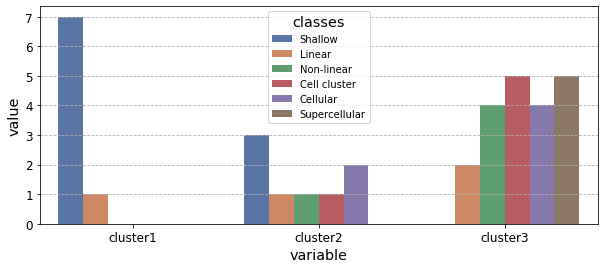

In [5]:
plt.figure(figsize=[10,4])
classes=["Shallow","Linear","Non-linear","Cell cluster","Cellular","Supercellular"]
cluster1 = [(tint_cluster.query("Cluster==0")["Class"]==c).sum() for c in classes]
cluster2 = [(tint_cluster.query("Cluster==2")["Class"]==c).sum() for c in classes]
cluster3 = [(tint_cluster.query("Cluster==1")["Class"]==c).sum() for c in classes]
class_count=pd.DataFrame({"classes":classes,"cluster1":cluster1, "cluster2":cluster2, "cluster3":cluster3})
print(class_count)
#sns.boxplot(data=pd.melt(class_count), x="variable", y="value")
plot=sns.barplot(data=pd.melt(class_count,"classes"),x="variable",hue="classes",y="value",orient="v",palette="deep")
ax=plt.gca()
ax.grid(axis="y",ls="--")

                  time rid  cluster
0  2006-09-24 01:41:00   2        0
1  2009-11-20 03:06:00   2        2
2  2010-03-06 03:30:00   2        1
3  2010-06-17 00:25:00   2        0
4  2011-11-18 07:04:00   2        2
5  2011-12-25 06:45:00   2        2
6  2012-02-26 09:11:00   2        1
7  2013-03-21 03:45:00   2        0
8  2015-02-28 09:25:00   2        2
9  2010-08-02 15:43:00  71        0
10 2012-08-10 04:21:00  71        0
11 2013-02-23 13:43:00  71        1
12 2014-10-14 11:39:00  71        0
13 2015-03-01 04:34:00  71        2
14 2015-12-16 02:03:00  71        1
15 2016-01-14 04:20:00  71        2
16 2016-06-04 03:42:00  71        0
17 2017-04-09 08:03:00  71        2
18 2010-12-16 03:25:00  66        1
19 2011-01-18 05:05:00  66        1
20 2011-10-07 19:22:00  50        1
21 2013-10-18 04:04:00  50        1
22 2013-11-23 09:45:00  66        1
23 2014-01-23 04:52:00  50        1
24 2016-01-29 04:22:00  50        1
25 2016-12-18 04:14:00  66        1
26 2018-02-13 07:05:00  50  

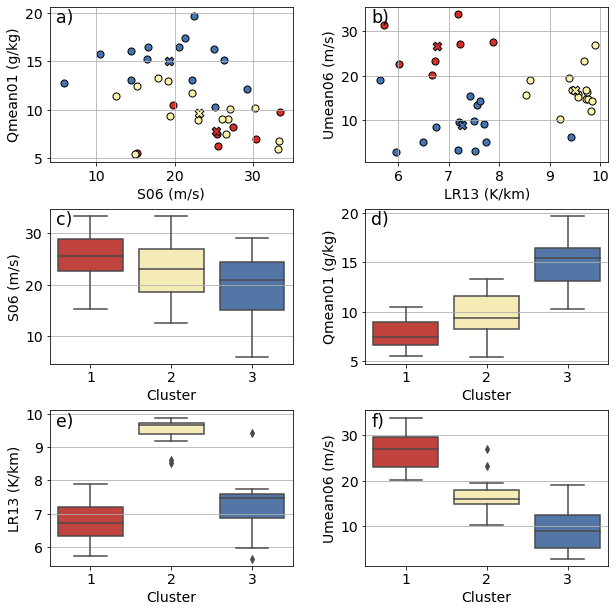

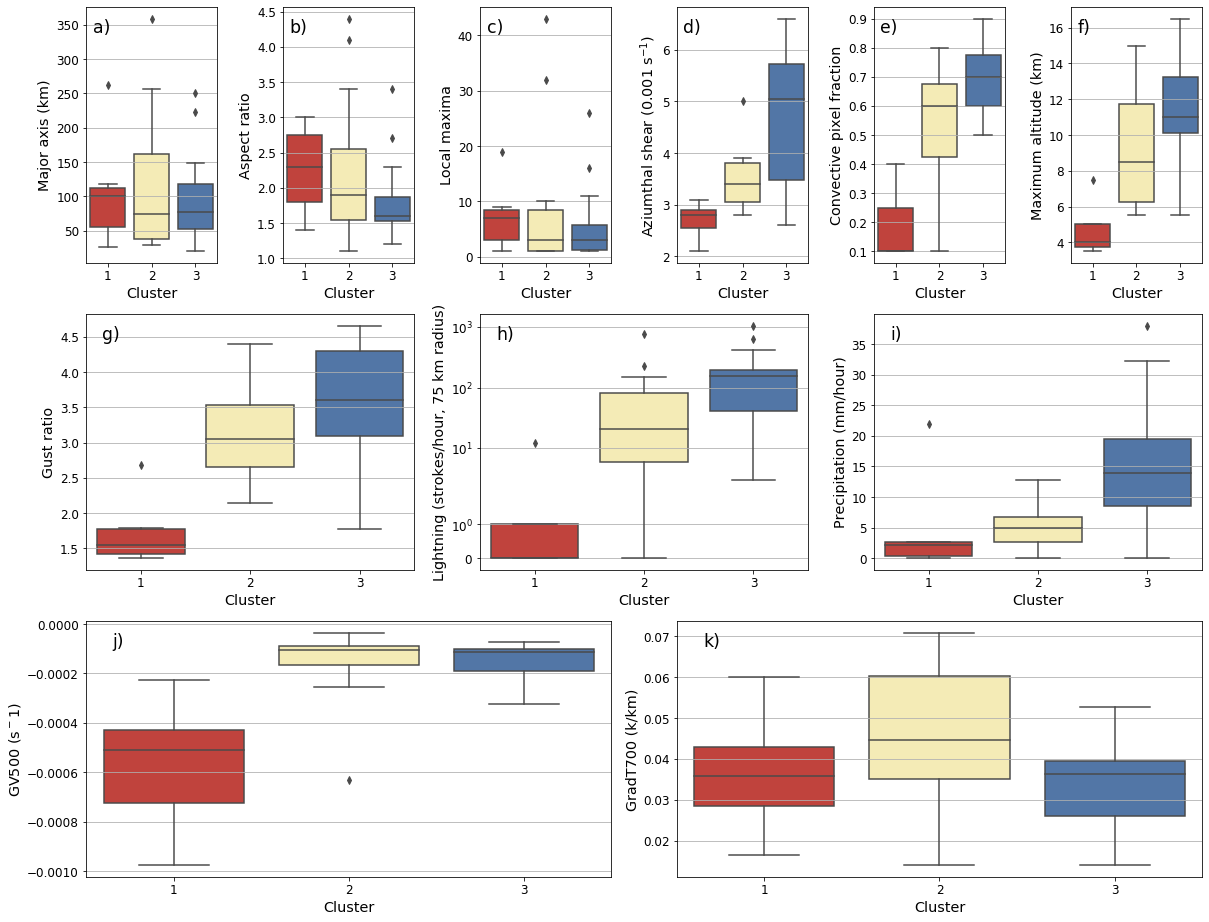

In [6]:
from sklearn.cluster import KMeans as kmeans
import seaborn as sns

df_norm = (df_barra - df_barra.min(axis=0)) / (df_barra.max(axis=0) - df_barra.min(axis=0))

mod=kmeans(n_clusters=3, verbose=0, random_state=0)
mod_fit=mod.fit(df_norm[var])
cluster_index = mod_fit.predict(df_norm[var])

#p = [plt.get_cmap("RdYlBu")(i) for i in np.linspace(0,1,len(np.unique(cluster_index)))]
p = [plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]

plt.figure(figsize=[10,14])
plt.rcParams.update({'axes.labelsize': 'medium', 'xtick.labelsize': 'medium', 'ytick.labelsize': 'medium'})
specify_order=True
order=[0,2,1]

ylabs = ["S06 (m/s)","Qmean01 (g/kg)","LR13 (K/km)","Umean06 (m/s)"]
letters = ["a","b","c","d","e","f","g","h","i","j","k"]

cnt=3
for v in df_barra.columns:
    plt.subplot(np.ceil((df_barra.shape[1]) / 2)+2,2,cnt)
    plt.text(0.025,0.9,letters[cnt-1]+")",transform=plt.gca().transAxes,size="xx-large")    
    if specify_order:
        sns.boxplot(data=[df_barra.loc[cluster_index==c][v] for c in order], palette=p)
        plt.xticks(np.arange(len(np.unique(cluster_index))), order)
    else:
        sns.boxplot(data=[df_barra.loc[cluster_index==c][v] for c in np.unique(cluster_index)], palette=p)
    if v in ["mu_cape"]:
        plt.yscale("symlog")
        plt.ylim([0,10000])
    plt.gca().grid(axis="y")
    plt.ylabel(ylabs[cnt-3],size=14)
    plt.xticks(ticks=[0,1,2],labels=[1,2,3])
    plt.xlabel("Cluster",size=14)
    plt.gca().tick_params(labelsize=14) 
    cnt=cnt+1

if specify_order:
    cnt=0
    plt.subplot(np.ceil((df_barra.shape[1]) / 2)+2,2,1)
    plt.text(0.025,0.9,letters[0]+")",transform=plt.gca().transAxes,size="xx-large")    
    for c in order:
        plt.scatter(df_barra.loc[cluster_index==c][var[0]], df_barra.loc[cluster_index==c][var[1]], c=[p[cnt]], edgecolors="k", s=50)
        plt.scatter(np.interp(mod_fit.cluster_centers_[c,np.where(np.array(var)==var[0])[0][0]], np.sort(df_norm[var[0]].values), np.sort(df_barra[var[0]].values)),
                    np.interp(mod_fit.cluster_centers_[c,np.where(np.array(var)==var[1])[0][0]], np.sort(df_norm[var[1]].values), np.sort(df_barra[var[1]].values)), c=[p[cnt]], marker="X", edgecolors="k",s=75)
        cnt=cnt+1
    if var[1] == "mu_cape":
        plt.yscale("symlog"); plt.ylim([0,10000]); 
    plt.gca().grid(); plt.xlabel("S06 (m/s)",size=14); plt.ylabel("Qmean01 (g/kg)",size=14)
    plt.gca().tick_params(labelsize=14)
    
    cnt=0
    plt.subplot(np.ceil((df_barra.shape[1]) / 2)+2,2,2)
    plt.text(0.025,0.9,letters[1]+")",transform=plt.gca().transAxes,size="xx-large")    
    for c in order:
        plt.scatter(df_barra.loc[cluster_index==c][var[2]], df_barra.loc[cluster_index==c][var[3]], c=[p[cnt]], edgecolors="k",s=50)
        plt.scatter(np.interp(mod_fit.cluster_centers_[c,np.where(np.array(var)==var[2])[0][0]], np.sort(df_norm[var[2]].values), np.sort(df_barra[var[2]].values)),
                    np.interp(mod_fit.cluster_centers_[c,np.where(np.array(var)==var[3])[0][0]], np.sort(df_norm[var[3]].values), np.sort(df_barra[var[3]].values)), c=[p[cnt]], marker="X", edgecolors="k",s=75)        
        cnt=cnt+1
    plt.gca().grid(); plt.ylabel("Umean06 (m/s)",size=14); plt.xlabel("LR13 (K/km)",size=14); plt.gca().tick_params(labelsize=14)

else:
    for c in np.arange(len(np.unique(cluster_index))):
        plt.scatter(df_barra.loc[cluster_index==c][var[1]], df_barra.loc[cluster_index==c][var[0]], c=[p[c]], edgecolors="k")
    if var[1] == "mu_cape":
        plt.yscale("symlog"); plt.ylim([0,10000])
    plt.gca().grid()

    plt.figure()
    for c in np.arange(len(np.unique(cluster_index))):
        plt.scatter(df_barra.loc[cluster_index==c][var[2]], df_barra.loc[cluster_index==c][var[3]], c=[p[c]], edgecolors="k")    
    plt.gca().grid()        

plt.subplots_adjust(hspace=0.3,wspace=0.3)        
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/kmeans_normed_barra.jpeg",quality=100)

tint = pd.read_csv("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/storm_stats.csv")
tint["time"] = pd.DatetimeIndex(tint.time).round("1D")
cluster_df = pd.DataFrame({"time":[d["time"][0] for d in details_list], "rid":[d["rid"] for d in details_list], "cluster":cluster_index})
cluster_df["time"] = pd.DatetimeIndex(cluster_df.time).round("1D")
synop = pd.read_csv("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/synop_stats.csv")
synop["time"] = pd.DatetimeIndex(synop["Unnamed: 0"]).round("1D")
obs = pd.read_csv("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/one_min_obs_stats.csv")
obs["time"] = pd.DatetimeIndex(obs["time"]).round("1D")
tint_cluster = pd.merge(cluster_df, tint, on="time").merge(synop, on="time").merge(obs, on="time").rename(columns={"cluster":"Cluster"})

plt.figure(figsize=[20,16])
plt.rcParams.update({'axes.labelsize': 'x-large', 'xtick.labelsize': 'large', 'ytick.labelsize': 'large'})
plt.subplot2grid((3,6), (0,0), rowspan=1, colspan=1); sns.boxplot(data=tint_cluster, x="Cluster", y="Major axis (km)", order=order, palette=p);plt.xticks(ticks=[0,1,2],labels=[1,2,3]); plt.gca().grid(axis="y"); plt.text(0.05,0.9,letters[0]+")",transform=plt.gca().transAxes,size="xx-large")
plt.subplot2grid((3,6), (0,1), rowspan=1, colspan=1);sns.boxplot(data=tint_cluster, x="Cluster", y="Aspect ratio", order=order, palette=p);plt.xticks(ticks=[0,1,2],labels=[1,2,3]); plt.gca().grid(axis="y"); plt.text(0.05,0.9,letters[1]+")",transform=plt.gca().transAxes,size="xx-large")
plt.subplot2grid((3,6), (0,2), rowspan=1, colspan=1);sns.boxplot(data=tint_cluster, x="Cluster", y="Local maxima", order=order, palette=p);plt.xticks(ticks=[0,1,2],labels=[1,2,3]); plt.gca().grid(axis="y"); plt.text(0.05,0.9,letters[2]+")",transform=plt.gca().transAxes,size="xx-large")
plt.subplot2grid((3,6), (0,3), rowspan=1, colspan=1);sns.boxplot(data=tint_cluster, x="Cluster", y="Aziumthal shear (s^-1)", order=order, palette=p);plt.xticks(ticks=[0,1,2],labels=[1,2,3]); plt.gca().grid(axis="y"); plt.ylabel("Aziumthal shear (0.001 s$^{-1}$)"); plt.text(0.05,0.9,letters[3]+")",transform=plt.gca().transAxes,size="xx-large")
plt.subplot2grid((3,6), (0,4), rowspan=1, colspan=1);sns.boxplot(data=tint_cluster, x="Cluster", y="Convective pixel fraction", order=order, palette=p);plt.xticks(ticks=[0,1,2],labels=[1,2,3]); plt.gca().grid(axis="y"); plt.text(0.05,0.9,letters[4]+")",transform=plt.gca().transAxes,size="xx-large")
plt.subplot2grid((3,6), (0,5), rowspan=1, colspan=1);sns.boxplot(data=tint_cluster, x="Cluster", y="Maximum altitude (km)", order=order, palette=p);plt.xticks(ticks=[0,1,2],labels=[1,2,3]); plt.gca().grid(axis="y"); plt.text(0.05,0.9,letters[5]+")",transform=plt.gca().transAxes,size="xx-large")
plt.subplot2grid((3,6), (2,0), rowspan=1, colspan=3);sns.boxplot(data=tint_cluster, x="Cluster", y="laplacian", order=order, palette=p); plt.ylabel("GV500 (s${^-1}$)");plt.xticks(ticks=[0,1,2],labels=[1,2,3]); plt.gca().grid(axis="y"); plt.text(0.05,0.9,letters[9]+")",transform=plt.gca().transAxes,size="xx-large")
plt.subplot2grid((3,6), (2,3), rowspan=1, colspan=3);sns.boxplot(data=tint_cluster, x="Cluster", y="wb_grad", order=order, palette=p); plt.ylabel("GradT700 (k/km)");plt.xticks(ticks=[0,1,2],labels=[1,2,3]); plt.gca().grid(axis="y"); plt.text(0.05,0.9,letters[10]+")",transform=plt.gca().transAxes,size="xx-large")
plt.subplot2grid((3,6), (1,0), rowspan=1, colspan=2);sns.boxplot(data=tint_cluster, x="Cluster", y="rab4", order=order, palette=p); plt.ylabel("Gust ratio");plt.xticks(ticks=[0,1,2],labels=[1,2,3]); plt.gca().grid(axis="y"); plt.text(0.05,0.9,letters[6]+")",transform=plt.gca().transAxes,size="xx-large")
plt.subplot2grid((3,6), (1,2), rowspan=1, colspan=2);sns.boxplot(data=tint_cluster, x="Cluster", y="lightning", order=order, palette=p); plt.ylabel("Lightning (strokes/hour, 75 km radius)");plt.xticks(ticks=[0,1,2],labels=[1,2,3]); plt.gca().grid(axis="y"); plt.yscale("symlog"); plt.text(0.05,0.9,letters[7]+")",transform=plt.gca().transAxes,size="xx-large")
plt.subplot2grid((3,6), (1,4), rowspan=1, colspan=2);sns.boxplot(data=tint_cluster, x="Cluster", y="pr", order=order, palette=p); plt.ylabel("Precipitation (mm/hour)");plt.xticks(ticks=[0,1,2],labels=[1,2,3]); plt.gca().grid(axis="y"); plt.text(0.05,0.9,letters[8]+")",transform=plt.gca().transAxes,size="xx-large")

plt.subplots_adjust(wspace=0.5)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/cluster_stats_barra.jpeg",quality=100)

print(pd.DataFrame({"time":[d["time"][0] for d in details_list], "rid":[d["rid"] for d in details_list], "cluster":cluster_index}))
print(pd.DataFrame({"time":[d["time"][0] for d in details_list], "rid":[d["rid"] for d in details_list], "cluster":cluster_index}).\
    groupby("cluster").rid.value_counts())

In [7]:
#Evaluate the clusters for ERA5 and BARRA

from sklearn import metrics

df_norm_barra = (df_barra - df_barra.min(axis=0)) / (df_barra.max(axis=0) - df_barra.min(axis=0))
df_norm_era5 = (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))

def fit_mod(df, var, random_state, n_clusters):
    mod=kmeans(n_clusters=n_clusters, verbose=0, random_state=random_state)
    mod_fit=mod.fit(df[var])
    cluster_index = mod_fit.predict(df[var])
    return mod_fit, cluster_index

sil_scores_mean_barra = []
sil_scores_5_barra = []
sil_scores_95_barra = []
sil_scores_mean_era5 = []
sil_scores_5_era5 = []
sil_scores_95_era5 = []
rand_mean = []
rand_5 = []
rand_95 = []
for n in tqdm.tqdm(np.arange(2,11)):
    out_barra = [fit_mod(df_norm_barra, var, r, n) for r in np.arange(1000)]
    sils = [metrics.silhouette_score(df_norm_barra, X[1]) for X in out_barra]
    sil_scores_mean_barra.append(np.mean(sils))
    sil_scores_5_barra.append(np.percentile(sils,5))
    sil_scores_95_barra.append(np.percentile(sils,95))    
    
    out_era5 = [fit_mod(df_norm_era5, var, r, n) for r in np.arange(1000)]
    sils = [metrics.silhouette_score(df_norm_era5, X[1]) for X in out_era5]
    sil_scores_mean_era5.append(np.mean(sils))
    sil_scores_5_era5.append(np.percentile(sils,5))
    sil_scores_95_era5.append(np.percentile(sils,95))   
    
    rands_temp = []
    for i in np.arange(len(out_barra)):
        preds_barra = out_barra[i][1]
        preds_era5 = out_era5[i][1]   
        rands_temp.append(metrics.adjusted_rand_score(preds_barra, preds_era5))
    rand_mean.append(np.mean(rands_temp))
    rand_5.append(np.percentile(rands_temp,5))
    rand_95.append(np.percentile(rands_temp,95))
    

100%|██████████| 9/9 [08:14<00:00, 54.97s/it]


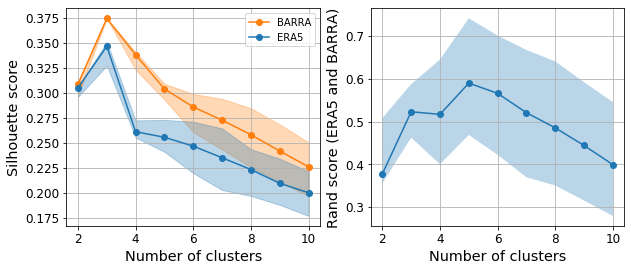

In [8]:
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(np.arange(2,11), sil_scores_mean_barra, marker="o", color="tab:orange", label="BARRA")
plt.fill_between(np.arange(2,11), sil_scores_5_barra, sil_scores_95_barra, alpha=0.3, color="tab:orange")

plt.plot(np.arange(2,11), sil_scores_mean_era5, marker="o", color="tab:blue", label="ERA5")
plt.fill_between(np.arange(2,11), sil_scores_5_era5, sil_scores_95_era5, alpha=0.3, color="tab:blue")

plt.ylabel("Silhouette score")
plt.xlabel("Number of clusters")
plt.gca().grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(2,11), rand_mean, marker="o")
plt.fill_between(np.arange(2,11), rand_5, rand_95, alpha=0.3)

plt.ylabel("Rand score (ERA5 and BARRA)")
plt.xlabel("Number of clusters")
plt.gca().grid()

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/cluster_choice.jpeg",quality=100)